In [1]:
import plotly.express as plx
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import scipy.stats as st

In [2]:
DATA_PATH = "../../data/input"

# Data loading

In [3]:
# Identify QC samples for median normalization correction later on
# A subbatch is defined as the samples batch between 2 QC pools.

def subbatch(x):
    if x['order'] <= 14 :
        return 0
    if x['order'] <= 26 :
        return 1
    if x['order'] <= 38 :
        return 2
    if x['order'] <= 50 :
        return 3
    if x['order'] <= 62 :
        return 4
    if x['order'] <= 74 :
        return 5
    if x['order'] <= 86 :
        return 6
    if x['order'] <= 101 :
        return 7
    else:
        return 8

In [4]:
df_data = pd.read_csv(os.path.join(DATA_PATH, 'internship_data_matrix.csv'))
df_feature_meta = pd.read_csv(os.path.join(DATA_PATH, 'internship_feature_metadata.csv'))
df_acq = pd.read_csv(os.path.join(DATA_PATH, 'internship_acquisition_list.csv'))

# Augment dataset with metadata
df_acq['sub_batch'] = df_acq.apply(lambda x : subbatch(x), axis=1)
df_data = df_data.merge(df_acq[['sample', 'class', 'order', 'batch', 'sub_batch']], on='sample')
df_data = df_data.melt(id_vars=['sample', 'class', 'order', 'batch', 'sub_batch'],value_name='intensity', var_name='feature')
df_data['feature_number'] = df_data['feature'].apply(lambda s : int(s.split('-')[1]))

# Filter classes, batch of interest and mass range of interest
df_data = df_data[df_data['class'].isin(['QC', 'Dunn', 'French', 'LMU']) & df_data['batch'] == 1]
df_glycans = df_feature_meta[df_feature_meta['mz'] > 500]
df_data = df_data.merge(df_glycans['feature'], on='feature', how='inner')

# Data processing

##  1- Rescale data to improve comparability

There are several ways to proceed.
* Global scaling normalization coefficient : ratio of peptide abundance to median peptide abundance measured across all samples
* Median pool normalisation : ratio of peptide abundance to median peptide abundance in the three neighbouring QCs. This approach is preferred as it acounts for intra batch effects.

In [5]:
# Compute the QC pool metabolites median intensities for each data sub_batch
pools_medians = df_data[df_data['class'] == 'QC'].groupby(['sub_batch', 'feature'])['intensity'].median().reset_index()
pools_medians = pools_medians.sort_values(['feature', 'sub_batch'])\
                             .groupby('feature')\
                             .rolling(3, min_periods=3, center=True).median().dropna()\
                             .reset_index('feature').rename(columns={'intensity' : 'med_QC_intensity'})

In [6]:
# Scale data intensities
df_data_corr = df_data[df_data['class'].isin(['Dunn', 'LMU', 'French'])].merge(pools_medians, on=['feature', 'sub_batch'])
df_data_corr['intensity_corr'] = df_data_corr['intensity'] / df_data_corr['med_QC_intensity']

## 2 - Select features which have a limited variability across samples of the same class

In [7]:
# Remove features with outliers in QC to compute robust CV on features using Inter quartile range 

df_QC = df_data[df_data['class'] == 'QC']
df_QC_summary = df_QC.groupby(['feature'])['intensity'].describe([.01, .99]).reset_index()
print(f"Before outliers removal, there are {df_QC['sample'].nunique()} samples.")

df_QC = df_QC.merge(df_QC_summary[['feature', '1%', '99%']], on='feature')
print(f"Each QC sample has at least 4 outliers :\n{df_QC[(df_QC['intensity'] < df_QC['1%']) | (df_QC['intensity'] > df_QC['99%']) ].groupby('sample').size()}.")

# Since the features first selection step relies on CV per feature, we can just remove feature with outlier value for each sample
df_QC = df_QC[(df_QC['intensity'] >= df_QC['1%']) & (df_QC['intensity'] <= df_QC['99%']) ]

Before outliers removal, there are 11 samples.
Each QC sample has at least 4 outliers :
sample
20241106-297-QC1       4
20241106-297-QC10     24
20241106-297-QC11     30
20241106-297-QC2     146
20241106-297-QC3      47
20241106-297-QC4      32
20241106-297-QC5       5
20241106-297-QC6     142
20241106-297-QC7      49
20241106-297-QC8       4
20241106-297-QC9       8
dtype: int64.


In [8]:
# Compute CV

cv_QC = df_QC.groupby('feature')['intensity'].agg(lambda x : x.std() / x.mean() * 100).reset_index().rename(columns={'intensity' : 'CV%'})
cv_QC.describe()

,CV%
count,248.000000
mean,17.911869
std,14.595272
min,5.142026
25%,11.267969
50%,13.800647
75%,19.499003
max,159.997537


According to [Instrumental Drift in Untargeted Metabolomics: Optimizing Data Quality with Intrastudy QC Samples](https://pmc.ncbi.nlm.nih.gov/articles/PMC10222478/#sec4-metabolites-13-00665), a accepted CV threshold for biomarker discovery is 20%.

In [9]:
# Select features which exhibit limited variability in QC

selected_feats = list(cv_QC[cv_QC['CV%'] <= 30]['feature'])
print(f"At this stage, {len(selected_feats)} features were selected")

At this stage, 225 features were selected


## 3 - Remove samples with outliers 

In [10]:
# First keep filtered features from step 2
df_data_process = df_data_corr[df_data_corr['feature'].isin(selected_feats)]

In [11]:
# Detect outliers

summ = df_data_process.groupby('feature')['intensity_corr'].describe([.01, .99]).reset_index()
df_data_process = df_data_process.merge(summ[['feature', '1%', '99%']], on='feature')
print("Number of outliers per sample : ")
nb_outliers = df_data_process[(df_data_process['intensity_corr'] < df_data_process['1%']) | (df_data_process['intensity_corr'] > df_data_process['99%']) ]\
                .groupby('sample').size().reset_index()
nb_outliers = nb_outliers.rename(columns={0:'nb_outliers'})
print(nb_outliers)

Number of outliers per sample : 
                    sample  nb_outliers
0     20241106-297-Dunn-10            4
1     20241106-297-Dunn-12            2
2     20241106-297-Dunn-13           24
3     20241106-297-Dunn-14            1
4     20241106-297-Dunn-17            7
5     20241106-297-Dunn-18            2
6     20241106-297-Dunn-19            1
7      20241106-297-Dunn-2            4
8     20241106-297-Dunn-20            1
9     20241106-297-Dunn-21           12
10    20241106-297-Dunn-24           51
11     20241106-297-Dunn-5           23
12     20241106-297-Dunn-6            2
13     20241106-297-Dunn-8            1
14  20241106-297-French-10            1
15  20241106-297-French-13            1
16  20241106-297-French-14            2
17  20241106-297-French-15           22
18  20241106-297-French-16            1
19  20241106-297-French-17            7
20  20241106-297-French-18           13
21  20241106-297-French-19            2
22   20241106-297-French-2            3
23  202

Since there is at least 1 outlier per sample, we can discard samples based on a number of outliers. Namely, with 166 selected features, we can fix that threshold to 5 outliers max. It means we allow an error of 3%.

In [12]:
# Filter samples

print(f"Number of samples per class before filtering :\n{df_data_process.drop_duplicates(['sample', 'class']).groupby('class').size()}")
samples_to_exclude = list(nb_outliers[nb_outliers['nb_outliers'] > 5]['sample'])
df_data_process = df_data_process[~df_data_process['sample'].isin(samples_to_exclude)]
print(f"Number of samples per class after filtering :\n{df_data_process.drop_duplicates(['sample', 'class']).groupby('class').size()}")

Number of samples per class before filtering :
class
Dunn      24
French    21
LMU       21
dtype: int64
Number of samples per class after filtering :
class
Dunn      19
French    16
LMU       16
dtype: int64


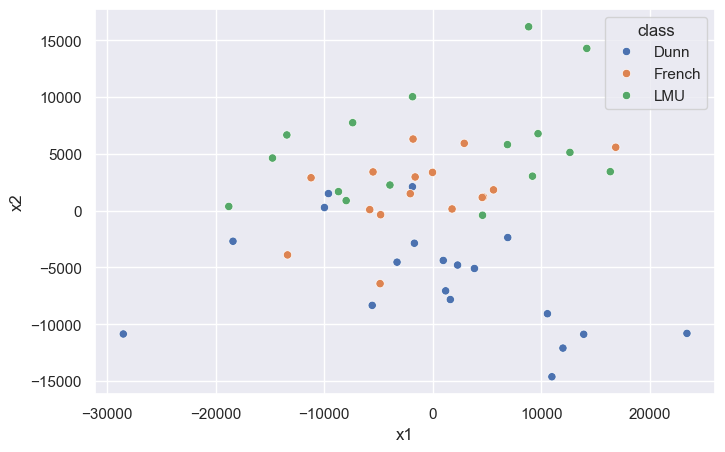

In [13]:
from sklearn.decomposition import PCA

df = df_data_process[['feature', 'intensity', 'sample', 'class']].groupby(['class','sample','feature']).first().unstack()
pca_2d = PCA(n_components=2)
X = df.to_numpy()
X_new = pca_2d.fit_transform(X)

sns.set(rc = {'figure.figsize':(8, 5)})
df_plot = pd.DataFrame(X_new, columns=['x1', 'x2'])
df_plot['class'] = [c for (c, i) in df.index]

fig = sns.scatterplot(df_plot, x='x1', y='x2', hue='class')

After data processing and feature engineering, we can start seeing 2 clusters with one cluster being data points from Dunn (Healthy).

## 4- Select features with a consistent support in detection on the same class

From the guidelines, selected features should have been detected in at least 70% of cases for a given class. 

## 5 Final selection

In [14]:
print(f"Final curated list contains {df_data_process['feature'].nunique()} features and {df_data_process['sample'].nunique()} samples.")

Final curated list contains 225 features and 51 samples.
